## **MINERIA DE DATOS CON CARBOHIDRATOS**

# OBTENIENDO SMILES
REQUERIMIENTOS: RDKit - Gregory A. Landrum
Researcher ETH Zurich

Este código obtiene los las estructuras de moleculas a partir de su nombre IUPAC a nombre común utilizando el API de cactus

**Instalar las librerias urlopen, quote y pandas**

Estas librerias permiten hacer busquedas por API y pandas para el manejo de dataframes

Las librerias asociadas a RDKit permiten la manipulación y análisis de datos químicos

In [1]:
# Install RDKit.
%%capture
!pip install rdkit-pypi

In [ ]:
from ipywidgets import interact, fixed, widgets
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.parse import quote

In [ ]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

Cargar el archivo con los nombres de los compuestos a los que se va a extraer el smiles

In [ ]:
file = '/content/Carbohydrates_test.xlsx'
data_frame = pd.read_excel(file, sheet_name='Hoja1')
data_frame

,Carbohydrate,Type,Subtype
0,D-Glyceraldehyde,Monosaccharides,aldose
1,L-Glyceraldehyde,Monosaccharides,aldose
2,D-Erythrose,Monosaccharides,aldose
3,D-Threose,Monosaccharides,aldose
4,D-Arabinose,Monosaccharides,aldose
5,L-Arabinose,Monosaccharides,aldose
6,D-Xylose,Monosaccharides,aldose
7,L-Xylose,Monosaccharides,aldose
8,D-Lyxose,Monosaccharides,aldose
9,L-Lyxose,Monosaccharides,aldose


**Función para la busqueda de SMILES**

Modificando el nombre de la molecula en la url se obtiene el smile de la base de datos cactus

In [ ]:
def getSmiles(nombre):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(nombre) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'No SMILE'

Realizar la busqueda de los smiles de las moleculas utilizando la función anterior

In [ ]:
SMILES = []
molecules =  list(data_frame['Carbohydrate'])
for i in molecules :
    smile = getSmiles(i)
    SMILES.append(smile)
    print(i, smile)

D-Glyceraldehyde OC[C@@H](O)C=O
L-Glyceraldehyde OC[C@H](O)C=O
D-Erythrose OC[C@@H](O)[C@@H](O)C=O
D-Threose OC[C@@H](O)[C@H](O)C=O
D-Arabinose OC[C@@H](O)[C@@H](O)[C@H](O)C=O
L-Arabinose OC[C@H](O)[C@H](O)[C@@H](O)C=O
D-Xylose OC[C@@H](O)[C@H](O)[C@@H](O)C=O
L-Xylose OC[C@H](O)[C@@H](O)[C@H](O)C=O
D-Lyxose OC[C@@H](O)[C@H](O)[C@H](O)C=O
L-Lyxose OC[C@H](O)[C@@H](O)[C@@H](O)C=O


Se crea un data frame en el que se juntan el nombre del lipido con su respectivo SMILE y se guardan en un archivo excel

In [ ]:
data_frame ['Smiles'] = SMILES
data_frame

,Carbohydrate,Type,Subtype,Smiles
0,D-Glyceraldehyde,Monosaccharides,aldose,OC[C@@H](O)C=O
1,L-Glyceraldehyde,Monosaccharides,aldose,OC[C@H](O)C=O
2,D-Erythrose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)C=O
3,D-Threose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)C=O
4,D-Arabinose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)[C@H](O)C=O
5,L-Arabinose,Monosaccharides,aldose,OC[C@H](O)[C@H](O)[C@@H](O)C=O
6,D-Xylose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)[C@@H](O)C=O
7,L-Xylose,Monosaccharides,aldose,OC[C@H](O)[C@@H](O)[C@H](O)C=O
8,D-Lyxose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)[C@H](O)C=O
9,L-Lyxose,Monosaccharides,aldose,OC[C@H](O)[C@@H](O)[C@@H](O)C=O


In [ ]:
data_frame.to_excel('Carbohydrates_smiles_test.xlsx', sheet_name='smiles')

# **CARGAR LOS DATOS COMPLETOS**

Para poder analizar los datos es necesario instalar la librería RDKit, para analisis de datos químicos

In [ ]:
new_file = '/content/Carbohydrates_smiles.xlsx'
data = pd.read_excel(new_file, sheet_name='smiles')
data

,Carbohydrate,Type,Subtype,Smiles
0,D-Glyceraldehyde,Monosaccharides,aldose,OC[C@@H](O)C=O
1,L-Glyceraldehyde,Monosaccharides,aldose,OC[C@H](O)C=O
2,D-Erythrose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)C=O
3,D-Threose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)C=O
4,D-Arabinose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)[C@H](O)C=O
...,...,...,...,...
107,Glucomannan,Polysaccharides,Heteropolysaccharides,C([C@@H]1[C@H]([C@@H]([C@@H]([C@@H](O1)O[C@@H]...
108,Xyloglucan,Polysaccharides,Heteropolysaccharides,COC1=C(C=CC(=C1)/C=C/C(=O)O[C@@H]2CO[C@@H]([C@...
109,4-O-Methylglucuronoxylan,Polysaccharides,Heteropolysaccharides,CC1C(C(C(C(O1)OC2C(C(COC2OC3C(COC(C3O)O)OC4C(C...
110,Chondroitin,Polysaccharides,Heteropolysaccharides,CC(=O)N[C@H]1[C@H]([C@H]([C@H](O[C@H]1O)CO)O)O...


Una vez cargados los datos es una buena práctica hacer un paneo de la catidad y tipo de datos que se tienen. Para esto primero exploramos la columna "Type" del data frame

Monosaccharides      77
Oligosaccharides     23
Polysaccharides      12
Name: Type, dtype: int64

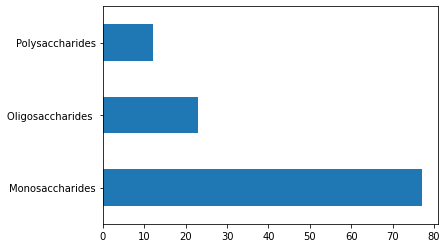

In [ ]:
count_type = data['Type'].value_counts()[:10]
count_type.plot(kind='barh')
count_type

Ahora exploramos la columna "subtype", especificamente los datos correspondientes a los monosacaridos, que son los que tienen mayor diversidad

aldose           23
Ketose           15
Aminosugars      14
Sugaracids       11
Deoxysugars       9
Sugaralcohols     5
Name: Subtype, dtype: int64

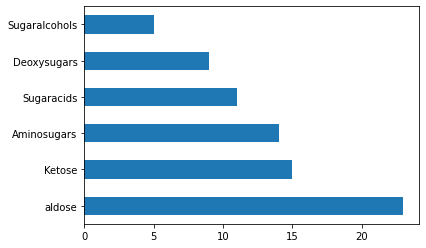

In [ ]:
Monosaccharides = data.iloc[:77]
count_subtype = Monosaccharides['Subtype'].value_counts()[:10]
count_subtype.plot(kind='barh')
count_subtype

El siguiente paso es analizar los datos correspondientes a oligosacaridos. Para esto se cargan solo los datos desde la fila 77 a la 100

Disaccharides       22
Tetrasaccharides     1
Name: Subtype, dtype: int64

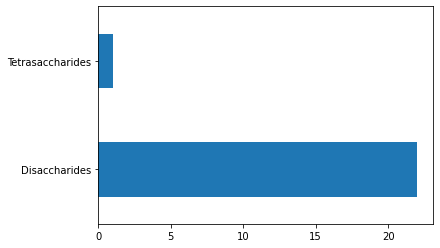

In [ ]:
Oligosaccharides = data.iloc[77:100]
count_subtype_o = Oligosaccharides['Subtype'].value_counts()[:10]
count_subtype_o.plot(kind='barh')
count_subtype_o

Finalmente se revisan los datos correspondiente a los polisacaridos

Homopolysaccharides      7
Heteropolysaccharides    5
Name: Subtype, dtype: int64

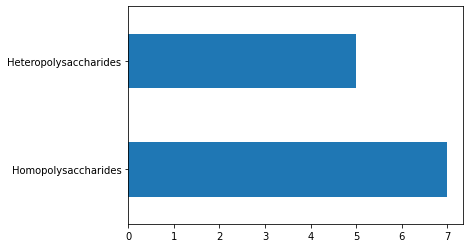

In [ ]:
Polysaccharides = data.iloc[100:]
count_subtype_p = Polysaccharides ['Subtype'].value_counts()[:10]
count_subtype_p.plot(kind='barh')
count_subtype_p

# ANALIZANDO LAS CARATERISTICAS ESTRUCTURALES Y FISICOQUÍMICAS DE CARBOHYDARTOS

RDKit permite general la estructura de una molecula a partir de su smiles, que es una codificación de la estructura quimica en forma de texto

https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system

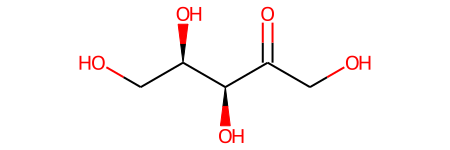

In [ ]:
all_smiles = data ['Smiles']
mol = random.choice(all_smiles)
structure = Chem.MolFromSmiles(mol)
structure

Lo primero que se debe hacer es configurar la función que sombrea la maxima estructura comun compartida entre un grupo dado de moleculas

In [ ]:
def highlight_molecules(molecules, mcs, number, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

El primer paso es analizar que subestructuras son compartidas entre los distintos tipos de carbohidratos presentes en el dataset. En primer lugar se hace la búsqueda para los monosacaridos

The CS contains 3 atoms and 2 bonds.


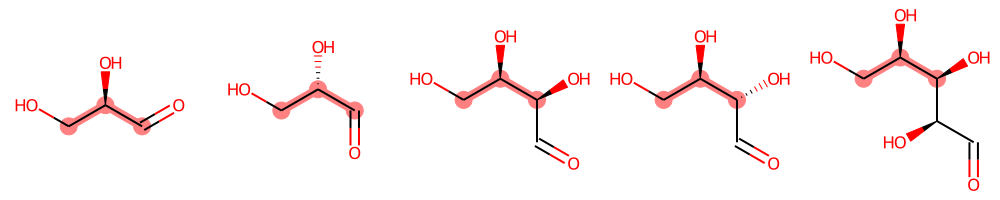

In [ ]:
Mon_smiles = Monosaccharides ['Smiles']
Mon_structure = [Chem.MolFromSmiles (smile) for smile in Mon_smiles ]
cm_mon_subst = rdFMCS.FindMCS(Mon_structure)
print(f"The CS contains {cm_mon_subst.numAtoms} atoms and {cm_mon_subst.numBonds} bonds.")
highlight_molecules(Mon_structure, cm_mon_subst, 5)

Luego se realiza la misma búsqueda para los oligosacaridos

The CS contains 16 atoms and 16 bonds.


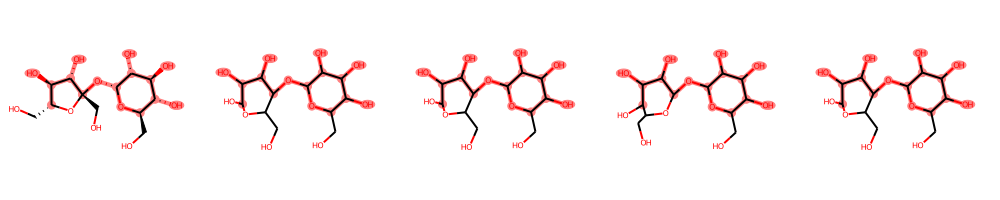

In [ ]:
Oligo_smiles = Oligosaccharides ['Smiles']
Oligo_structure = [Chem.MolFromSmiles (smile) for smile in Oligo_smiles ]
cm_oligo_subst = rdFMCS.FindMCS(Oligo_structure)
print(f"The CS contains {cm_oligo_subst.numAtoms} atoms and {cm_oligo_subst.numBonds} bonds.")
highlight_molecules(Oligo_structure, cm_oligo_subst, 5)

Finalmente se lleva a cabo la búsqueda para los polisacaridos

The CS contains 7 atoms and 6 bonds.


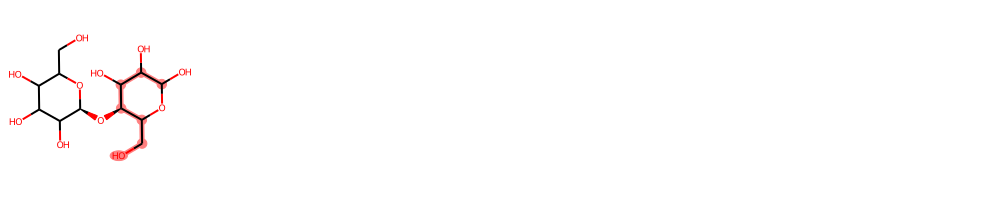

In [ ]:
Pol_smiles = Polysaccharides ['Smiles']
Pol_structure = [Chem.MolFromSmiles (smile) for smile in Pol_smiles ]
cm_pol_subst = rdFMCS.FindMCS(Pol_structure)
print(f"The CS contains {cm_pol_subst.numAtoms} atoms and {cm_pol_subst.numBonds} bonds.")
highlight_molecules(Pol_structure, cm_pol_subst, 1)

RDKit permite imprimir solo la parte de la subestructura que se detecto como común en la busqueda realizada

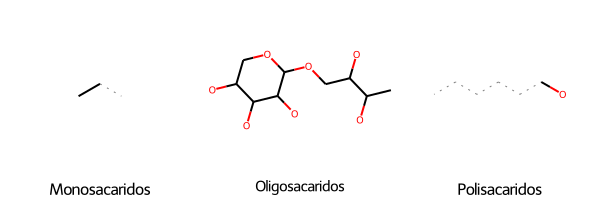

In [ ]:
m1 = Chem.MolFromSmarts(cm_mon_subst.smartsString)
m2 = Chem.MolFromSmarts(cm_oligo_subst.smartsString)
m3 = Chem.MolFromSmarts(cm_pol_subst.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "Monosacaridos",
        "Oligosacaridos",
        "Polisacaridos",
    ],
)

# CALCULANDO DESCRIPTORES MOLECULARES CON RDKIT

RDKit también perimite el calculo de descriptores moleculares. son propiedades fisicoquímicas que se calculan a partir de una estructura por métodos computacionales, por lo que son un reflejo cuantitativo o describen numéricamente a cada una de las moléculas.

En este caso vamos a calcular los siguientes descriptores moleculares: numero de atomos pesados, grupos hidroxilo, grupos carbonilo, grupos carboxilo y grupos fenilo

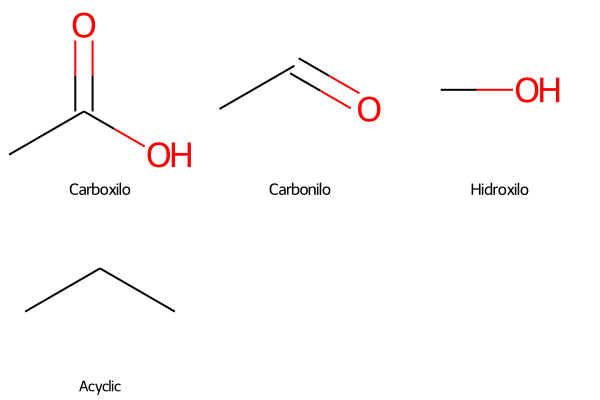

In [ ]:
caboxyl_group = Chem.MolFromSmiles('CC(=O)O')
carbonyl_group = Chem.MolFromSmiles('C(=O)C')
hydroxyl_group = Chem.MolFromSmiles('C-O')
acyclic_group = Chem.MolFromSmiles('CCC')
Draw.MolsToGridImage(
    [caboxyl_group, carbonyl_group, hydroxyl_group, acyclic_group],
    legends=[
        "Carboxilo",
        "Carbonilo",
        "Hidroxilo",
        "Acyclic",
    ],
)

Para esto vamos a usar la Match de RDKit que busca por subestructuras especificas en conjunto de moleculas dados

In [ ]:
Heavy_atoms = []
count_carboxyl = []
count_carbonyl = []
count_hydroxyl = []
count_acyclic = []

for smile in all_smiles: 
  #Generate the structure of the molecule
  mol = Chem.MolFromSmiles(smile)

  # Get heavy atoms count 
  heavy_atoms_count = mol.GetNumHeavyAtoms()
  Heavy_atoms.append(heavy_atoms_count)

  #Get number of caboxyl groups
  matches_caboxyl = mol.GetSubstructMatches(caboxyl_group)
  count_carboxyl.append(len(matches_caboxyl))

  #Get number of carbonyl groups
  matches_carbonyl = mol.GetSubstructMatches(carbonyl_group)
  count_carbonyl.append(len(matches_carbonyl))

  #Get number of hydroxyl groups
  matches_hydroxyl = mol.GetSubstructMatches(hydroxyl_group)
  count_hydroxyl.append(len(matches_hydroxyl))

  #Get number of phenyl groups
  matches_acyclic = mol.GetSubstructMatches(acyclic_group)
  count_acyclic.append(len(matches_acyclic))

Ahora se agregan los nuevos parametros calculados a los datos originales para compilarlos

In [ ]:
data ['Heavy atoms'], data ['Carboxyl groups'], data ['Carbonyl groups'] = [Heavy_atoms, count_carboxyl, count_carbonyl]
data

,Carbohydrate,Type,Subtype,Smiles,Heavy atoms,Carboxyl groups,Carbonyl groups
0,D-Glyceraldehyde,Monosaccharides,aldose,OC[C@@H](O)C=O,6,0,1
1,L-Glyceraldehyde,Monosaccharides,aldose,OC[C@H](O)C=O,6,0,1
2,D-Erythrose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)C=O,8,0,1
3,D-Threose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)C=O,8,0,1
4,D-Arabinose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)[C@H](O)C=O,10,0,1
...,...,...,...,...,...,...,...
107,Glucomannan,Polysaccharides,Heteropolysaccharides,C([C@@H]1[C@H]([C@@H]([C@@H]([C@@H](O1)O[C@@H]...,45,0,0
108,Xyloglucan,Polysaccharides,Heteropolysaccharides,COC1=C(C=CC(=C1)/C=C/C(=O)O[C@@H]2CO[C@@H]([C@...,34,1,2
109,4-O-Methylglucuronoxylan,Polysaccharides,Heteropolysaccharides,CC1C(C(C(C(O1)OC2C(C(COC2OC3C(COC(C3O)O)OC4C(C...,51,1,1
110,Chondroitin,Polysaccharides,Heteropolysaccharides,CC(=O)N[C@H]1[C@H]([C@H]([C@H](O[C@H]1O)CO)O)O...,26,1,2


In [ ]:
data ['Hydroxyl groups'], data ['Acyclic groups'] = [count_hydroxyl, count_acyclic]
data

,Carbohydrate,Type,Subtype,Smiles,Heavy atoms,Carboxyl groups,Carbonyl groups,Hydroxyl groups,Acyclic groups
0,D-Glyceraldehyde,Monosaccharides,aldose,OC[C@@H](O)C=O,6,0,1,2,1
1,L-Glyceraldehyde,Monosaccharides,aldose,OC[C@H](O)C=O,6,0,1,2,1
2,D-Erythrose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)C=O,8,0,1,3,2
3,D-Threose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)C=O,8,0,1,3,2
4,D-Arabinose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)[C@H](O)C=O,10,0,1,4,3
...,...,...,...,...,...,...,...,...,...
107,Glucomannan,Polysaccharides,Heteropolysaccharides,C([C@@H]1[C@H]([C@@H]([C@@H]([C@@H](O1)O[C@@H]...,45,0,0,28,16
108,Xyloglucan,Polysaccharides,Heteropolysaccharides,COC1=C(C=CC(=C1)/C=C/C(=O)O[C@@H]2CO[C@@H]([C@...,34,1,2,15,7
109,4-O-Methylglucuronoxylan,Polysaccharides,Heteropolysaccharides,CC1C(C(C(C(O1)OC2C(C(COC2OC3C(COC(C3O)O)OC4C(C...,51,1,1,32,17
110,Chondroitin,Polysaccharides,Heteropolysaccharides,CC(=O)N[C@H]1[C@H]([C@H]([C@H](O[C@H]1O)CO)O)O...,26,1,2,12,6


Una vez compilados los datos se guardan en un archivo excel para su posterior uso

In [ ]:
data.to_excel('Carbohydrates_descriptors_clase.xlsx', sheet_name='data')

#TALLER RDKit: Análisis de diferencias estructurales entre monosacaridos

Para realizar este taller se debe cargar el archivo de smiles y el archivo de descriptores generado anteriormente. No es necesario correr las celdas anteriores



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
data_descriptors = '/content/Carbohydrates_descriptors.xlsx'
data_descriptors = pd.read_excel(data_descriptors, sheet_name='data')
data_descriptors

,Carbohydrate,Type,Subtype,Smiles,Heavy atoms,Carboxyl groups,Carbonyl groups,Hydroxyl groups,Acyclic groups
0,D-Glyceraldehyde,Monosaccharides,aldose,OC[C@@H](O)C=O,6,0,1,2,1
1,L-Glyceraldehyde,Monosaccharides,aldose,OC[C@H](O)C=O,6,0,1,2,1
2,D-Erythrose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)C=O,8,0,1,3,2
3,D-Threose,Monosaccharides,aldose,OC[C@@H](O)[C@H](O)C=O,8,0,1,3,2
4,D-Arabinose,Monosaccharides,aldose,OC[C@@H](O)[C@@H](O)[C@H](O)C=O,10,0,1,4,3
...,...,...,...,...,...,...,...,...,...
107,Glucomannan,Polysaccharides,Heteropolysaccharides,C([C@@H]1[C@H]([C@@H]([C@@H]([C@@H](O1)O[C@@H]...,45,0,0,28,16
108,Xyloglucan,Polysaccharides,Heteropolysaccharides,COC1=C(C=CC(=C1)/C=C/C(=O)O[C@@H]2CO[C@@H]([C@...,34,1,2,15,7
109,4-O-Methylglucuronoxylan,Polysaccharides,Heteropolysaccharides,CC1C(C(C(C(O1)OC2C(C(COC2OC3C(COC(C3O)O)OC4C(C...,51,1,1,32,17
110,Chondroitin,Polysaccharides,Heteropolysaccharides,CC(=O)N[C@H]1[C@H]([C@H]([C@H](O[C@H]1O)CO)O)O...,26,1,2,12,6


1. Hacer un análisis de de correlación de los descriptores calculados utilizando el indice de correlación de Pearson. Para esto ejecute las celdas de codigo en los siguientes bloques. Explique los resultados

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

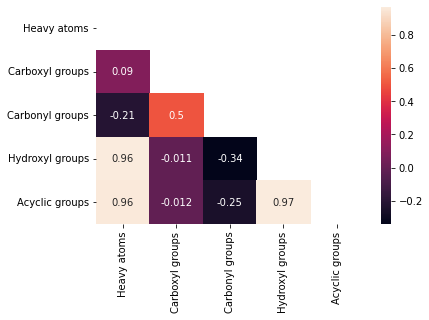

In [ ]:
correlation_data = data_descriptors.drop(['Carbohydrate', 'Smiles', 'Type', 'Subtype'], axis=1)
correlation_matrix = correlation_data.corr()
matrix = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot = True, mask=matrix)
plt.show()

2. Gráfique el número de atomos pesados vs el numero de grupos aliciclicos. También grafique el número de atomos pesados vs el número de grupos hidroxilo. Explique los resultados

Text(0, 0.5, 'Number of acyclic gropus')

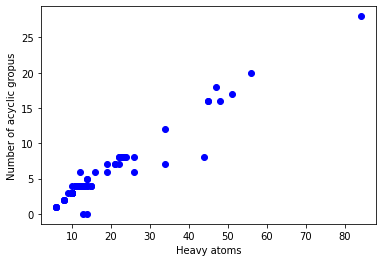

In [ ]:
x = data_descriptors ['Heavy atoms']
y = data_descriptors ['Acyclic groups']
plt.scatter(x, y, c ="blue")
plt.xlabel("Heavy atoms")
plt.ylabel("Number of acyclic gropus")

Text(0, 0.5, 'Number of hydroxyl gropus')

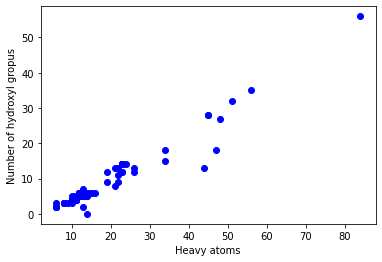

In [ ]:
x = data_descriptors ['Heavy atoms']
y = data_descriptors ['Hydroxyl groups']
plt.scatter(x, y, c ="blue")
plt.xlabel("Heavy atoms")
plt.ylabel("Number of hydroxyl gropus")